__<span style="background-color:#ffffe0">第5章　時系列データを活用したビジネス事例</span>__

# 5.7　広告・販促効果を見える化し最適化するMMM（スポーツジム）
※MMM=マーケティング・ミックス・モデリング

## ステップ1：準備

### 必要なモジュールの読み込み

In [1]:
#
# 必要なモジュールの読み込み
#

import numpy as np
import pandas as pd
import datetime

from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import basinhopping

from pmdarima import auto_arima
from pmdarima import model_selection

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import optuna

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフスタイル
plt.rcParams['figure.figsize'] = [12, 9] #グラフサイズ
plt.rcParams['font.size'] = 14 #フォントサイズ

### データセットの読み込み

In [2]:
#
# 必要なデータセット（時系列データ）の読み込み
#

dataset = 'chap5_9.csv'
df = pd.read_csv(
    dataset,
    parse_dates=['Week'],
    index_col='Week')

print(df) #確認

              Sales     TVCM  Newspaper     Web
Week                                           
2016-01-03  1940348  1312200          0       0
2016-01-10  2813841        0     502900  237400
2016-01-17  2225457        0     432100  200600
2016-01-24  1661417        0     338400       0
2016-01-31  1778688        0          0  234000
...             ...      ...        ...     ...
2019-11-24  1086821        0          0       0
2019-12-01  2083404        0     516700  166800
2019-12-08  1638062        0          0  206600
2019-12-15  1643600        0     664500       0
2019-12-22  1634904        0          0  197600

[208 rows x 4 columns]


### 学習データとテストデータ（直近52週間※1年間）に分割

In [3]:
#
# データセットを学習データとテストデータ（直近52週間）に分割
#

teat_length = 52

df_train, df_test = model_selection.train_test_split(
    df,test_size=teat_length)

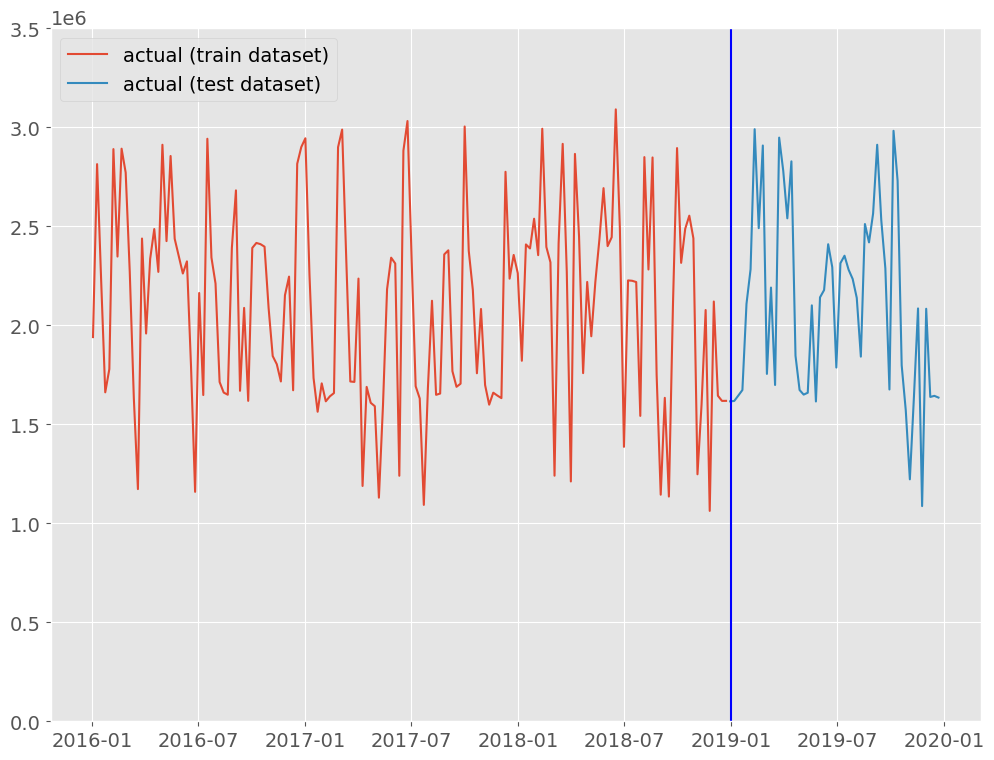

In [4]:
#
# グラフ化
#

fig, ax = plt.subplots()

ax.plot(
    df_train.index, 
    df_train.Sales, 
    label="actual (train dataset)")
ax.plot(
    df_test.index, 
    df_test.Sales, 
    label="actual (test dataset)")
ax.axvline(
    datetime.datetime(2019,1,1),
    color='blue') 

ax.set_ylim(0, 3.5e6)
plt.legend()
plt.show()

In [5]:
#
# 説明変数Xと目的変数yに分解
#

# 全データ期間
X = df.drop(columns=['Sales'])
y = df['Sales']

# 学習データ期間
X_train = df_train.drop(columns=['Sales'])
y_train = df_train['Sales']

# テストデータ期間
X_test = df_test.drop(columns=['Sales'])
y_test = df_test['Sales']

### キャリーオーバー効果モデル

In [6]:
#
# キャリーオーバー効果モデルの関数
#

def carryover(X: np.ndarray, length, peak, rate1, rate2, c1, c2):
    X = np.append(np.zeros(length-1), X)
    
    Ws = np.zeros(length)
    
    for l in range(length):
        if l<peak:
            W = rate1**(abs(l-peak)**c1)
        else:
            W = rate2**(abs(l-peak)**c2)
        Ws[length-1-l] = W
    
    carryover_X = []
    
    for i in range(length-1, len(X)):
        X_array = X[i-length+1:i+1]
        Xi = sum(X_array * Ws)/sum(Ws)
        carryover_X.append(Xi)
        
    return np.array(carryover_X)

Text(0.5, 1.0, 'length=10 peak=1 rate1=0.9 rate2=0.8 c1=1 c2=2')

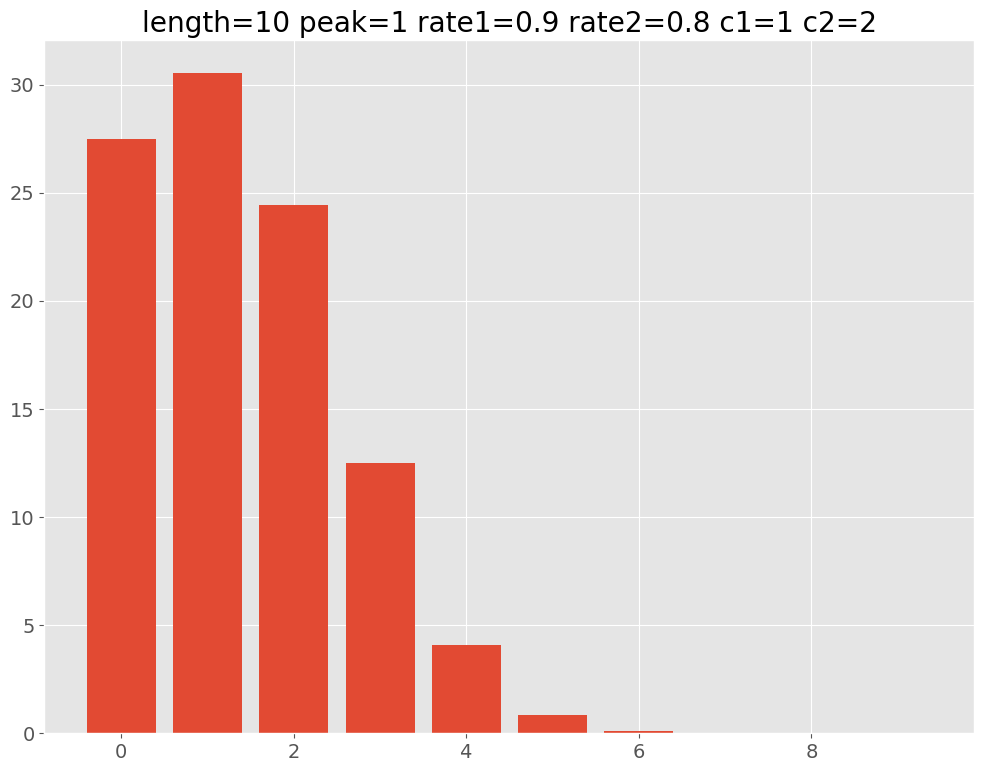

In [7]:
#
# キャリーオーバー効果モデルの出力例
#

## サンプルデータ
sample_data = pd.DataFrame([100,0,0,0,0,0,0,0,0,0]) 

## キャリーオーバー効果
sample_carryover = carryover(
    sample_data,10,1,0.9,0.8,1,2) 

## グラフ
plt.bar(sample_data.index, sample_carryover) 
plt.title('length=10 peak=1 rate1=0.9 rate2=0.8 c1=1 c2=2')

In [8]:
#
# キャリーオーバー効果モデルのクラス
#

class Carryover(BaseEstimator, TransformerMixin):
    # 初期化
    def __init__(self, length=4, peak=1, 
                 rate1=0.5, rate2=0.5, 
                 c1=1, c2=1):
        self.length = length
        self.peak = peak
        self.rate1 = rate1
        self.rate2 = rate2
        self.c1 = c1
        self.c2 = c2
        
    # 学習        
    def fit(self, X, y=None):
        return self
    
    # 処理（入力→出力）
    def transform(self, X: np.ndarray):
        return carryover(X, self.length, self.peak, 
                         self.rate1, self.rate2, 
                         self.c1, self.c2)

### 飽和関数の定義

In [9]:
#
# 飽和モデル（ロジスティック曲線）の関数
#

def saturation(X: np.ndarray,K,b,c,m):
    return K/(1+b*np.exp(-c*(X-m)))

<Axes: >

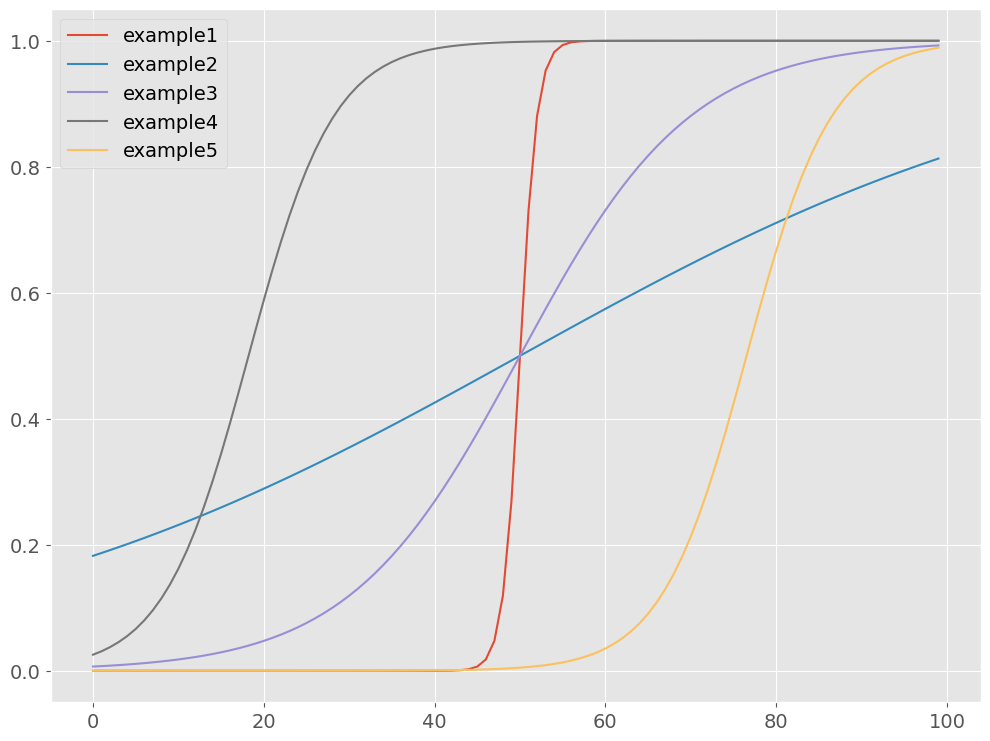

In [10]:
#
# 飽和モデル（ロジスティック曲線）の出力例
#

sample_data = pd.DataFrame(range(100)) #入力データ

sample_sat = pd.DataFrame(index=sample_data.index)
sample_sat['example1'] = saturation(sample_data,1,1,1,50) 
sample_sat['example2'] = saturation(sample_data,1,1,0.03,50) 
sample_sat['example3'] = saturation(sample_data,1,1,0.1,50) 
sample_sat['example4'] = saturation(sample_data,1,0.7,0.2,20)
sample_sat['example5'] = saturation(sample_data,1,0.5,0.2,80)

sample_sat.plot() #グラフ

In [11]:
#
# 飽和モデル（ロジスティック関数）のクラス
#

class Saturation(BaseEstimator, TransformerMixin):
    
    # 初期化
    def __init__(self, K=1.0, b=1.0, c=0.1, m=100.0):
        self.K = K
        self.b = b
        self.c = c
        self.m = m
    
    # 学習
    def fit(self, X, y=None):
        return self
    
    # 処理（入力→出力）
    def transform(self, X):
        return saturation(X,self.K, self.b, self.c, self.m).reshape(-1,1)

### 最適なハイパーパラメータを探索する関数

In [12]:
#
# 最適なハイパーパラメータを探索する関数
#

def MMM_arima_params_search(X, y, n_trials=1000):

    #
    # optunaの目的関数の設定
    #

    def objective(trial):

        # TVCM
        ## 飽和効果
        TVCM_K = trial.suggest_float(
            "TVCM_K", 
            np.min(X.TVCM), np.max(X.TVCM))
        TVCM_b = trial.suggest_float(
            "TVCM_b",
            0, 10)
        TVCM_c = trial.suggest_float(
            "TVCM_c",
            0, 1)
        TVCM_m = trial.suggest_float(
            "TVCM_m",
            np.min(X.TVCM), np.max(X.TVCM))
        TVCM_Saturation = Saturation(
            K=TVCM_K,
            b=TVCM_b,
            c=TVCM_c,
            m=TVCM_m)
        ## キャリーオーバー効果
        TVCM_length = trial.suggest_int(
            "TVCM_length",
            3,14)
        TVCM_peak = trial.suggest_int(
            "TVCM_peak",
            0,2)
        TVCM_rate1 = trial.suggest_float(
            "TVCM_rate1",
            0,1)
        TVCM_rate2 = trial.suggest_float(
            "TVCM_rate2",
            0,1)
        TVCM_c1 = trial.suggest_float(
            "TVCM_c1",
            0,3)
        TVCM_c2 = trial.suggest_float(
            "TVCM_c2",
            0,3)
        TVCM_Carryover = Carryover(
            length=TVCM_length,
            peak=TVCM_peak,
            rate1=TVCM_rate1,
            rate2=TVCM_rate2,
            c1=TVCM_c1,
            c2=TVCM_c2)

        # Newspaper
        ## 飽和効果
        Newspaper_K = trial.suggest_float(
            "Newspaper_K",
            np.min(X.Newspaper), np.max(X.Newspaper))
        Newspaper_b = trial.suggest_float(
            "Newspaper_b",
            0, 10)
        Newspaper_c = trial.suggest_float(
            "Newspaper_c",
            0, 1)
        Newspaper_m = trial.suggest_float(
            "Newspaper_m",
            np.min(X.Newspaper), np.max(X.Newspaper))
        Newspaper_Saturation = Saturation(
            K=Newspaper_K,
            b=Newspaper_b,
            c=Newspaper_c,
            m=Newspaper_m)
        ## キャリーオーバー効果
        Newspaper_length = trial.suggest_int(
            "Newspaper_length",
            3,14)
        Newspaper_peak = trial.suggest_int(
            "Newspaper_peak",
            0,2)
        Newspaper_rate1 = trial.suggest_float(
            "Newspaper_rate1",
            0,1)
        Newspaper_rate2 = trial.suggest_float(
            "Newspaper_rate2",
            0,1)
        Newspaper_c1 = trial.suggest_float(
            "Newspaper_c1",
            0,3)
        Newspaper_c2 = trial.suggest_float(
            "Newspaper_c2",
            0,3)
        Newspaper_Carryover = Carryover(
            length=Newspaper_length,
            peak=Newspaper_peak,
            rate1=Newspaper_rate1,
            rate2=Newspaper_rate2,
            c1=Newspaper_c1,
            c2=Newspaper_c2)

        # Web
        ## 飽和効果
        Web_K = trial.suggest_float(
            "Web_K",
            np.min(X.Web), np.max(X.Web))
        Web_b = trial.suggest_float(
            "Web_b",
            0, 10)
        Web_c = trial.suggest_float(
            "Web_c",
            0, 1)
        Web_m = trial.suggest_float(
            "Web_m",
            np.min(X.Web), np.max(X.Web))
        Web_Saturation = Saturation(
            K=Web_K,
            b=Web_b,
            c=Web_c,
            m=Web_m)
        ## キャリーオーバー効果
        Web_length = trial.suggest_int(
            "Web_length",
            3,14)
        Web_peak = trial.suggest_int(
            "Web_peak",
            0,2)
        Web_rate1 = trial.suggest_float(
            "Web_rate1",
            0,1)
        Web_rate2 = trial.suggest_float(
            "Web_rate2",
            0,1)
        Web_c1 = trial.suggest_float(
            "Web_c1",
            0,3)
        Web_c2 = trial.suggest_float(
            "Web_c2",
            0,3)
        Web_Carryover = Carryover(
            length=Web_length,
            peak=Web_peak,
            rate1=Web_rate1,
            rate2=Web_rate2,
            c1=Web_c1,
            c2=Web_c2)

        # 変換器（Adstock）のパイプライン化
        adstock = ColumnTransformer(
            [
             ('TVCM_pipe', Pipeline([
                 ('TVCM_carryover', TVCM_Carryover),
                 ('TVCM_saturation', TVCM_Saturation)
             ]), ['TVCM']),
             ('Newspaper_pipe', Pipeline([
                 ('Newspaper_carryover', Newspaper_Carryover),
                 ('Newspaper_saturation', Newspaper_Saturation)
             ]), ['Newspaper']),
             ('Web_pipe', Pipeline([
                 ('Web_carryover', Web_Carryover),
                 ('Web_saturation', Web_Saturation)
             ]), ['Web']),
            ],
            remainder='passthrough'
        )

        # Xの変換
        X_=adstock.fit_transform(X)

        # ARIMAモデル学習
        MMM=auto_arima(y,X_,with_intercept=True)

        return mean_squared_error(y, MMM.predict_in_sample(X_))
    
    #
    # ハイパーパラメータ探索
    #

    # ログ非出力
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    # 目的関数の最適化を実行する
    study = optuna.create_study(direction="minimize")
    study.optimize(objective,
                   n_trials=n_trials,
                   n_jobs=-1)
    #
    # 探索結果（最適解）
    #

    return study.best_params

In [13]:
#
# 最適ハイパーパラメータで学習する関数
#

def MMM_arima_gen(X, y, best_params):

    # 変換器のインスタンス生成
    TVCM_saturation = Saturation(
        best_params.get('TVCM_K'),
        best_params.get('TVCM_b'),
        best_params.get('TVCM_c'),
        best_params.get('TVCM_m'))
    TVCM_carryover = Carryover(
        best_params.get('TVCM_length'),
        best_params.get('TVCM_peak'),
        best_params.get('TVCM_rate1'),
        best_params.get('TVCM_rate2'),
        best_params.get('TVCM_c1'),
        best_params.get('TVCM_c2'))
    Newspaper_saturation = Saturation(
        best_params.get('Newspaper_K'),
        best_params.get('Newspaper_b'),
        best_params.get('Newspaper_c'),
        best_params.get('Newspaper_m'))
    Newspaper_carryover = Carryover(
        best_params.get('Newspaper_length'),
        best_params.get('Newspaper_peak'),
        best_params.get('Newspaper_rate1'),
        best_params.get('Newspaper_rate2'),
        best_params.get('Newspaper_c1'),
        best_params.get('Newspaper_c2'))
    Web_saturation = Saturation(
        best_params.get('Web_K'),
        best_params.get('Web_b'),
        best_params.get('Web_c'),
        best_params.get('Web_m'))
    Web_carryover = Carryover(
        best_params.get('Web_length'),
        best_params.get('Web_peak'),
        best_params.get('Web_rate1'),
        best_params.get('Web_rate2'),
        best_params.get('Web_c1'),
        best_params.get('Web_c2'))

    # 変換器のパイプライン
    adstock = ColumnTransformer(
        [
         ('TVCM_pipe', Pipeline([
             ('TVCM_carryover', TVCM_carryover),
             ('TVCM_saturation', TVCM_saturation)
         ]), ['TVCM']),
         ('Newspaper_pipe', Pipeline([
             ('Newspaper_carryover', Newspaper_carryover),
             ('Newspaper_saturation', Newspaper_saturation)
         ]), ['Newspaper']),
         ('Web_pipe', Pipeline([
             ('Web_carryover', Web_carryover),
             ('Web_saturation', Web_saturation)
         ]), ['Web']),
        ],
        remainder='passthrough'
    )

    # 説明変数Xを変換器で変換
    X_=adstock.fit_transform(X)

    # ARIMAモデルで学習
    MMM = auto_arima(y, X_, with_intercept=True)

    # 学習済みモデル
    return MMM,adstock

## ステップ2：MMMの作り方の検討

### 学習データで学習

In [14]:
#
# 最適なハイパーパラメータの探索（学習データ）
#

train_params = MMM_arima_params_search(X_train, y_train)

In [15]:
#
# 最適なハイパーパラメータで学習（学習データ）
#

# 学習
MMM_train, adstock_train = MMM_arima_gen(
    X_train, y_train, train_params)

In [16]:
#
# 精度評価（学習データ）
#

# 説明変数Xを変換器で変換
X_train_=adstock_train.transform(X_train)

# 予測
train_pred = MMM_train.predict_in_sample(X_train_)

# 精度指標（テストデータ）
print('RMSE:\n',
      np.sqrt(mean_squared_error(y_train, train_pred)))
print('MAE:\n',
      mean_absolute_error(y_train, train_pred))
print('MAPE:\n',
      mean_absolute_percentage_error(y_train, train_pred))

RMSE:
 68406.00183607393
MAE:
 54398.22292572513
MAPE:
 0.026568680040134535


### テストデータで精度評価

In [17]:
#
# 精度評価（テストデータ）
#

# 説明変数Xを変換器で変換
X_test_=adstock_train.transform(X_test)

# 予測
test_pred = MMM_train.predict(teat_length, X_test_)

# 精度指標（テストデータ）
print('RMSE:\n',
      np.sqrt(mean_squared_error(y_test, test_pred)))
print('MAE:\n',
      mean_absolute_error(y_test, test_pred))
print('MAPE:\n',
      mean_absolute_percentage_error(y_test, test_pred))

RMSE:
 86653.62512924288
MAE:
 73375.6338942918
MAPE:
 0.03528965338651986


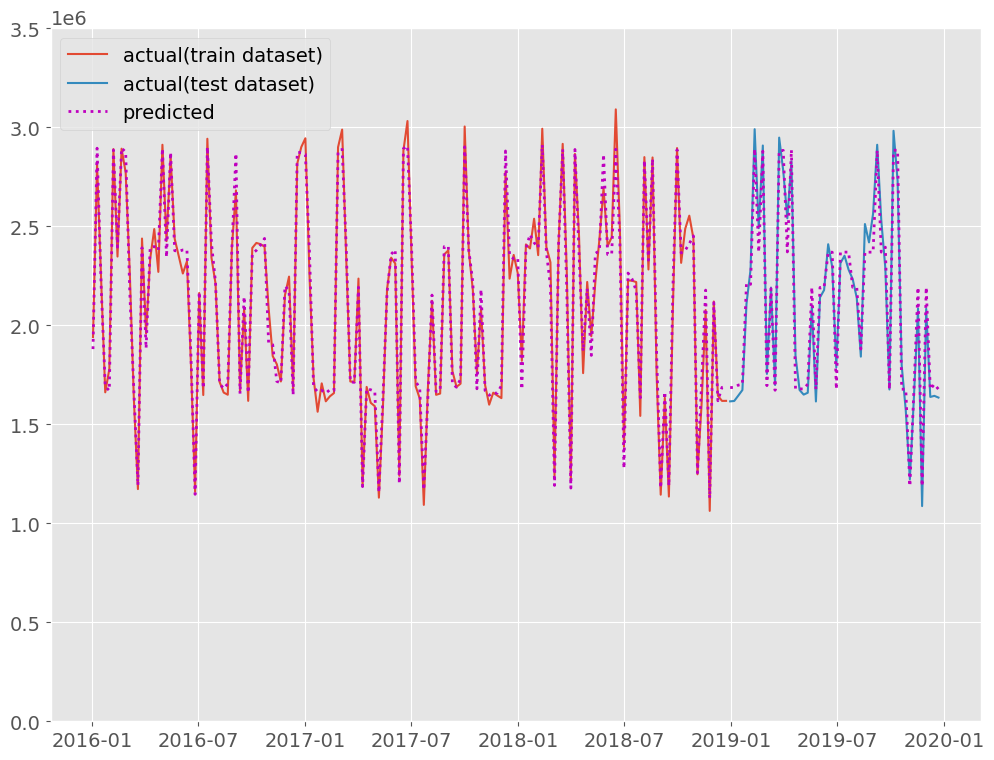

In [18]:
#
# グラフ化
#

fig, ax = plt.subplots()

ax.plot(y_train.index, 
        y_train.values, 
        label="actual(train dataset)")
ax.plot(y_test.index, 
        y_test.values, 
        label="actual(test dataset)")
ax.plot(y_train.index, 
        train_pred, 
        linestyle="dotted", 
        lw=2,
        color="m")
ax.plot(y_test.index, 
        test_pred, 
        label="predicted", 
        linestyle="dotted", 
        lw=2, 
        color="m") 

ax.set_ylim(0, 3.5e6)
plt.legend()
plt.show()

## ステップ3：MMMの構築（全データ期間）

In [19]:
#
# 最適なハイパーパラメータの探索（全データ期間）
#

best_params = MMM_arima_params_search(X, y)

In [20]:
#
# 最適なハイパーパラメータで学習（全データ期間）
#

# 学習
MMM, adstock = MMM_arima_gen(X, y, best_params)

In [21]:
#
# 精度評価
#

# 説明変数Xを変換器で変換
X_=adstock.transform(X)

# 予測
y_pred = MMM.predict_in_sample(X_)

# 精度指標（テストデータ）
print('RMSE:\n',
      np.sqrt(mean_squared_error(y, y_pred)))
print('MAE:\n',
      mean_absolute_error(y, y_pred))
print('MAPE:\n',
      mean_absolute_percentage_error(y, y_pred))

RMSE:
 76393.37393868488
MAE:
 61789.40610250085
MAPE:
 0.030481445700898925


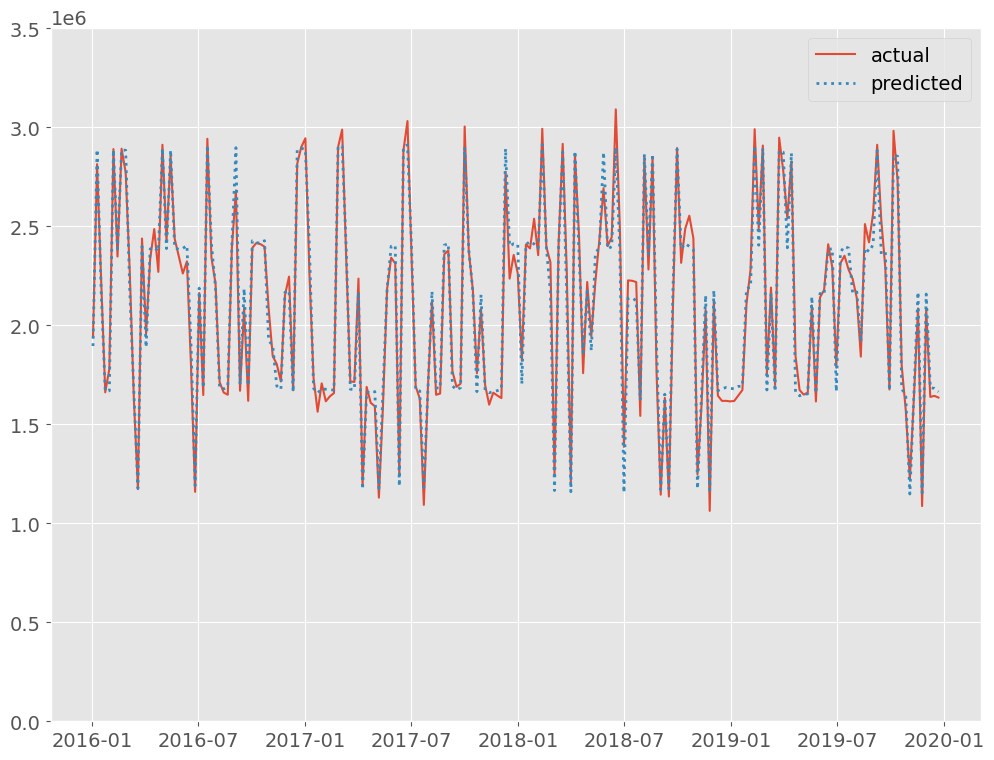

In [22]:
#
# グラフ化
#

fig, ax = plt.subplots()

ax.plot(y.index, 
        y, 
        label="actual")
ax.plot(y.index, 
        y_pred, 
        label="predicted", 
        linestyle="dotted", 
        lw=2)

ax.set_ylim(0, 3.5e6)
plt.legend()
plt.show()

## ステップ4：効果等算出

### 売上貢献度の算定

In [23]:
#
# 貢献度の算定
#

# 目的変数y（売上）の予測
pred = pd.DataFrame(
    np.array(y_pred),
    index=X.index,
    columns=['y'])

# 各媒体による売上の予測

## 説明変数の係数
coef = np.empty(len(X.columns))
for i in range(len(X.columns)):
    coef[i] = float(MMM.summary().tables[1].data[2+i][1])

## 媒体
for i in range(len(X.columns)):
    pred[X.columns[i]] = X_[:,i]*coef[i]
    
## Base
pred['Base'] = pred['y'] - pred.drop(columns='y').sum(axis=1)

# 予測値の補正
correction_factor = y.div(pred['y'], axis=0)   #補正係数
pred_adj = pred.mul(correction_factor, axis=0) #補正後の予測値

# 各媒体の貢献度だけ抽出
contribution = pred_adj[['Base', 'Web', 'Newspaper', 'TVCM']]

# 確認
print(contribution) 

                    Base            Web      Newspaper           TVCM
Week                                                                 
2016-01-03  1.200970e+06       0.000000       0.000000  739378.488896
2016-01-10  1.140399e+06  481703.354735  488101.922116  703636.470070
2016-01-17  1.205972e+06  506379.116156  513105.456888       0.000000
2016-01-24  1.162555e+06       0.000000  498862.213665       0.000000
2016-01-31  1.251764e+06  526923.583169       0.000000       0.000000
...                  ...            ...            ...            ...
2019-11-24  1.086821e+06       0.000000       0.000000       0.000000
2019-12-01  1.122344e+06  477359.584148  483700.452308       0.000000
2019-12-08  1.157395e+06  480666.590110       0.000000       0.000000
2019-12-15  1.153845e+06       0.000000  489755.317279       0.000000
2019-12-22  1.149153e+06  485751.312328       0.000000       0.000000

[208 rows x 4 columns]


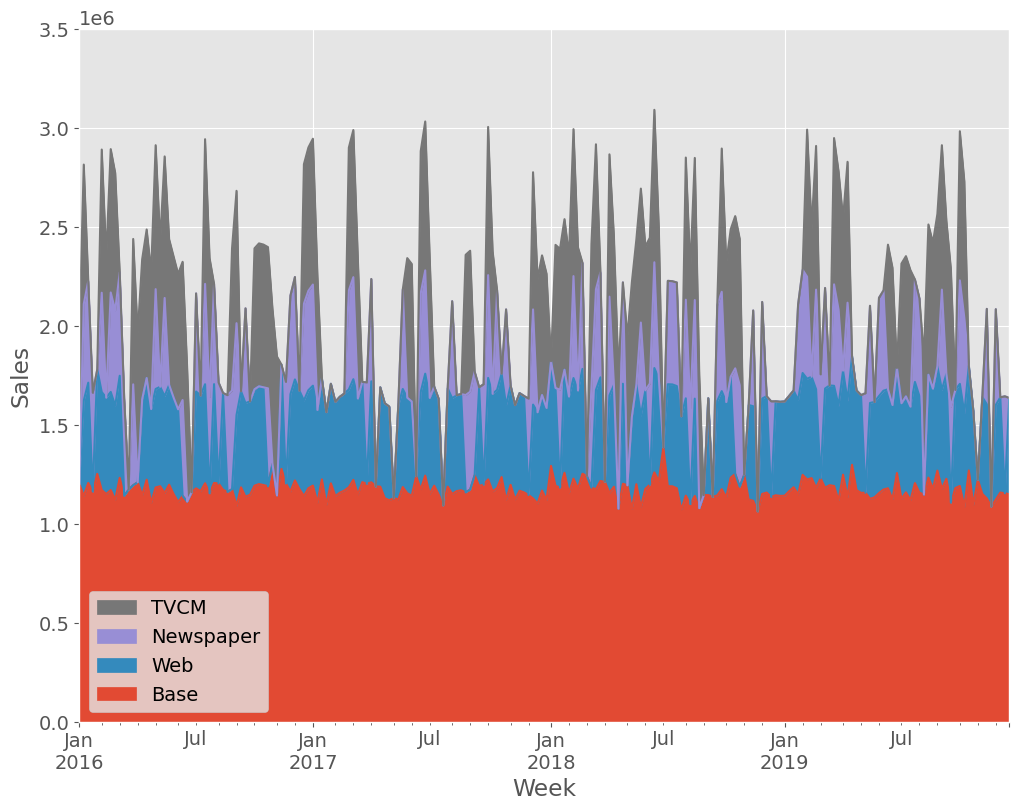

In [24]:
#
# グラフ化
#

ax = (contribution
      .plot.area(
          ylabel='Sales',
          xlabel='Week')
     )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
ax.set_ylim(0, 3.5e6)
plt.show()

In [25]:
#
# 貢献度の構成比の算出
#

# 媒体別の貢献度の合計
contribution_sum = contribution.sum(axis=0)

# 集計結果の出力
print('売上貢献度（円）:\n'
      + str(contribution_sum)
      + '\n')

print('売上貢献度（構成比）:\n'
      + str(contribution_sum/contribution_sum.sum())
      + '\n')

売上貢献度（円）:
Base         2.439881e+08
Web          7.754499e+07
Newspaper    4.564069e+07
TVCM         7.057538e+07
dtype: float64

売上貢献度（構成比）:
Base         0.557370
Web          0.177145
Newspaper    0.104262
TVCM         0.161223
dtype: float64



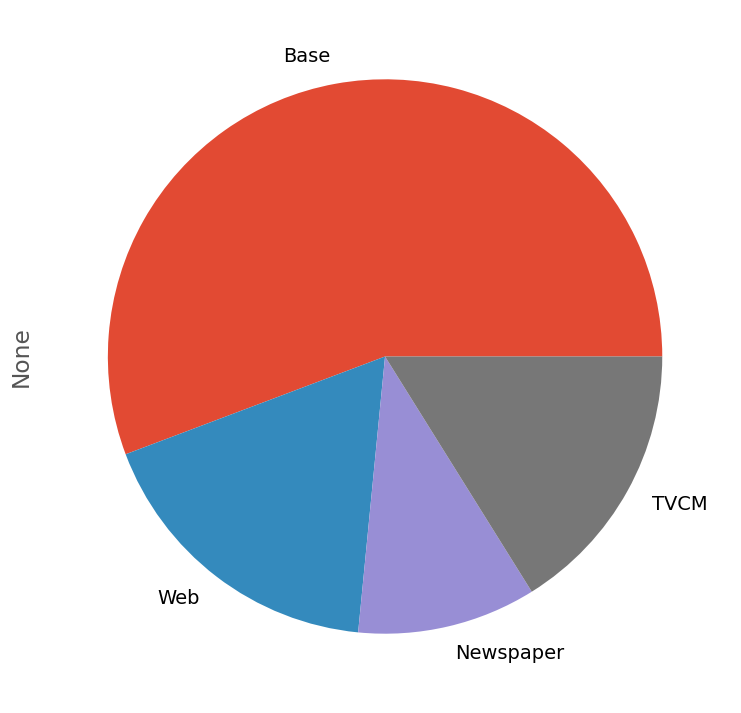

In [26]:
#
# グラフ化
#

contribution_sum.plot.pie()
plt.show()

### マーケティングROIの算定

In [27]:
#
# マーケティングROIの算定
#

# 各媒体のコストの合計
cost_sum = X.sum(axis=0)

# 各媒体の貢献度だけ抽出
contribution = pred_adj[['TVCM', 'Newspaper', 'Web']]

# 各媒体のROIの計算
ROI = (contribution.sum(axis=0) - cost_sum)/cost_sum

print('ROI:\n', ROI, sep='') #確認

ROI:
TVCM         0.213730
Newspaper   -0.007513
Web          1.475159
dtype: float64


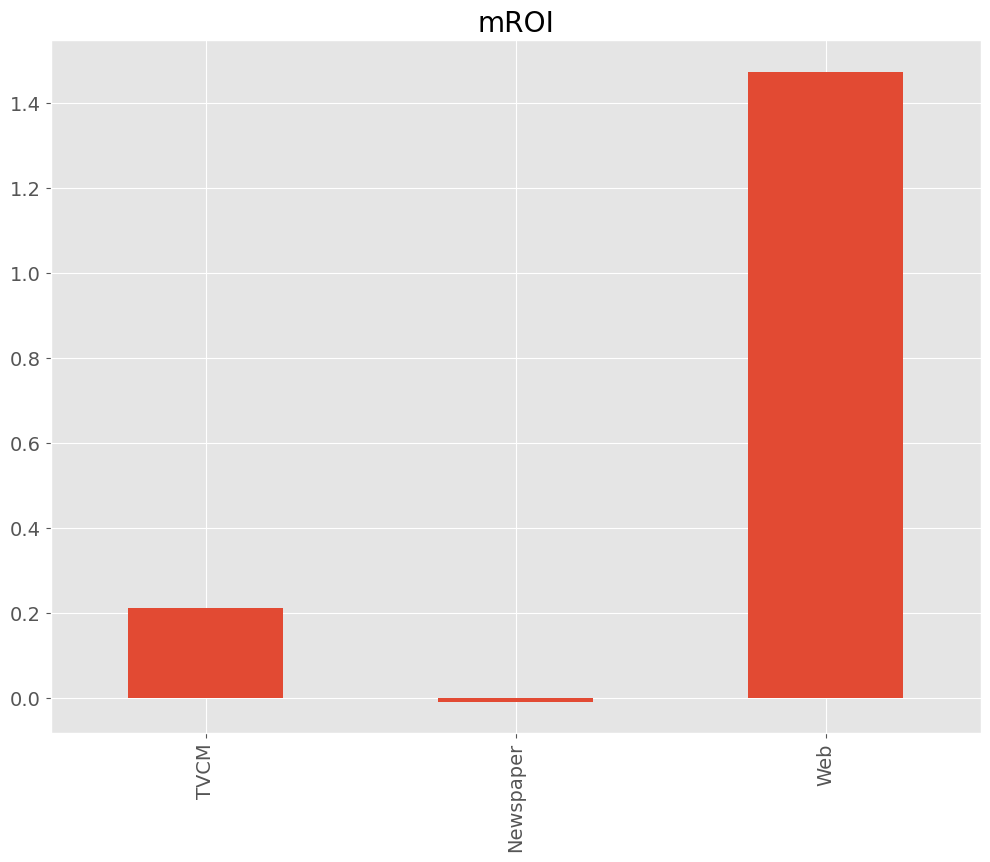

In [28]:
#
#グラフ化
#

ROI.plot.bar()
plt.title('mROI')
plt.show()

## ステップ5：広告コストの最適配分

### 振り返り（直近1年間(52週間)）

#### 最適化する期間のデータ

In [29]:
#
# 最適化する直近1年間（52週間）のデータ抽出
#

term = 52

X_before = X[-term:].copy()

#### 最適化問題の設定

In [30]:
#
# 目的関数
#

def func(x):
    x_pd = pd.DataFrame(
        x.reshape(term, len(X.columns)), 
        columns=X.columns)
    x_pd_=adstock_train.transform(x_pd)
    return -1*MMM_train.predict(term,x_pd_).sum()

#
# 制約条件
#

# コスト一定制約
con = {"type":"eq","fun": lambda x: cost_all-x.sum()}

# 変数の下限・上限
lower = [0] * X_before.size
upper = [np.inf] * X_before.size

In [31]:
#
# 最適化
#

# コスト全体
cost_all=X_before.values.ravel().sum()

# 初期値設定
x_0 = np.full(X_before.size, 0)

# 最適化ソルバー（局所最適探索エンジン）の設定
minimizer_kwargs = dict(
    method="SLSQP",
    bounds=Bounds(lower,upper),
    constraints=(con))

# 最適化実行（グローバル最適解の探索）
res = basinhopping(
    func,
    x_0,
    minimizer_kwargs=minimizer_kwargs,
    niter=1000, 
    T=10, 
    stepsize=100000,
    seed=0,
)

#### 最適化の結果

In [32]:
#
# 最適解
#

X_after = pd.DataFrame(
    res.x.reshape(len(X_before), 
                  len(X_before.columns)), 
    columns=X_before.columns,
    index=X_before.index)

print(X_after) #確認

                     TVCM      Newspaper            Web
Week                                                   
2018-12-30  201295.661868  187474.644243  139720.675979
2019-01-06  221261.554877  273052.193090  158840.403177
2019-01-13  213202.391218  236666.582449  227136.685481
2019-01-20  229842.527590  217949.449437  180194.756776
2019-01-27  194818.823483  179975.330640  205255.264860
2019-02-03  201724.047674  162018.686005  190309.317640
2019-02-10  217650.254420  234301.694597  272943.571460
2019-02-17  234592.391926  197723.594552  208696.883779
2019-02-24  269650.322182  208322.758783  184308.714197
2019-03-03  219855.653561  229124.558684  194569.489952
2019-03-10  199686.730208  289306.945714  250878.081208
2019-03-17  252215.924916  161170.063955  198669.715038
2019-03-24  205746.236489  189841.791386  235122.165583
2019-03-31  240781.634821  205321.886703  222556.439310
2019-04-07  221379.352542  194372.839456  204276.268361
2019-04-14  217002.660294  245824.352904  219602

In [33]:
#
# 売上
#

# 実際
Sales_actual = y[-term:].sum()
print ('Sales(actual):\n', Sales_actual)

# 最適配分時
X_after_ = adstock_train.transform(X_after)
Sales_optimized = MMM_train.predict(term, X_after_).sum()
print ('Sales(optimized):\n',Sales_optimized)

Sales(actual):
 109594445
Sales(optimized):
 124141142.3966217


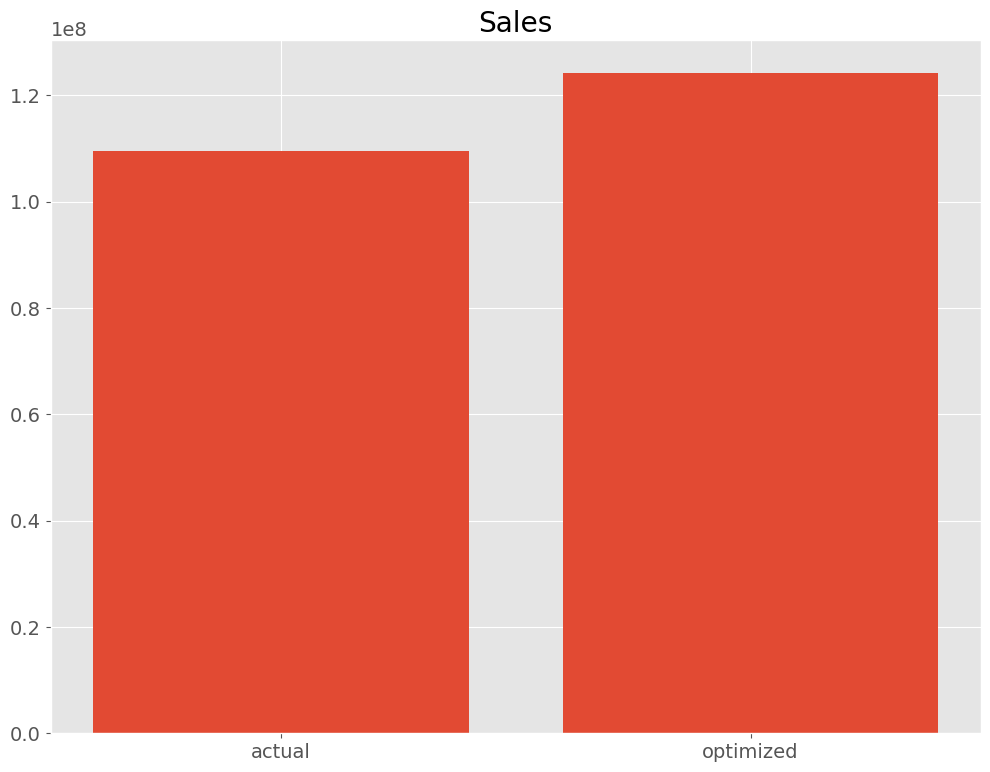

In [34]:
#
# グラフ化：売上
#

labels = ['actual','optimized']
values = [Sales_actual,Sales_optimized]

plt.title('Sales')
plt.bar(labels, values)
plt.show()

In [37]:
#
# 最適予算配分（構成比）
#

# 最適化前（実投資）の構成比
X_before_ratio = X_before.sum()/X_before.sum().sum()

print('最適化前（実投資）の構成比:\n'
      + str(X_before_ratio)
      + '\n')

# 最適投資の構成比
X_after_ratio = X_after.sum()/X_after.sum().sum()

print('最適投資の構成比::\n'
      + str(X_after_ratio)
      + '\n')

最適化前（実投資）の構成比:
TVCM         0.397076
Newspaper    0.339156
Web          0.263768
dtype: float64

最適投資の構成比::
TVCM         0.350590
Newspaper    0.330033
Web          0.319377
dtype: float64



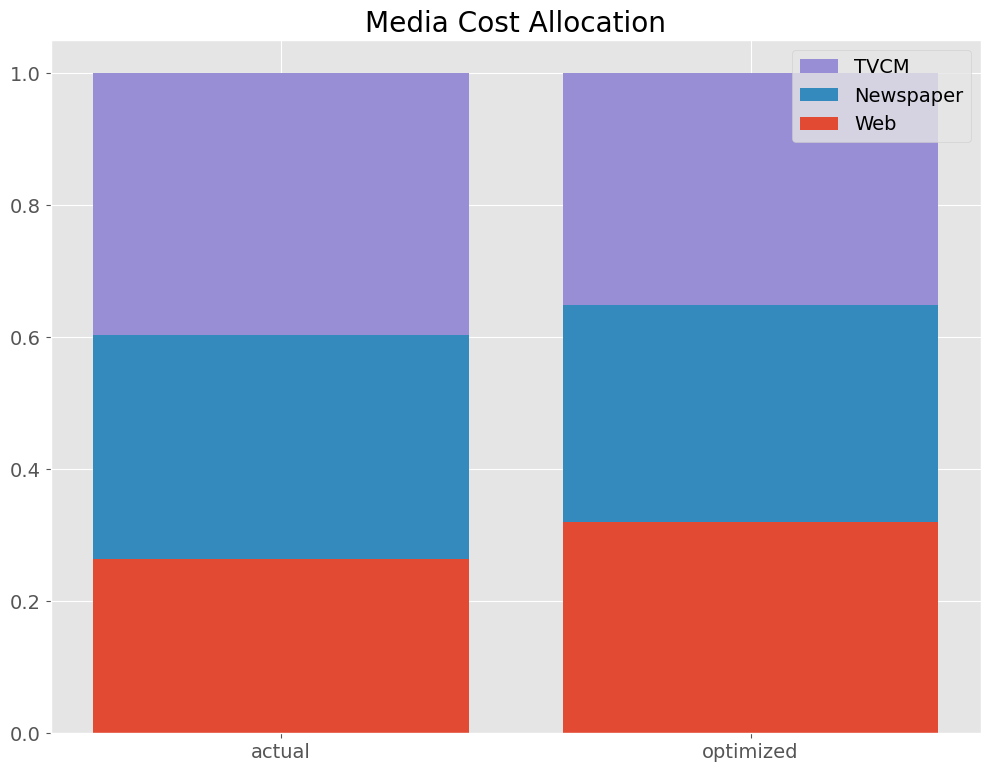

In [38]:
#
# グラフ化：最適予算配分（構成比）
#

labels = ['actual', 'optimized']

TVCM_values = np.array([X_before_ratio[0],X_after_ratio[0]])
Newspaper_values = np.array([X_before_ratio[1],X_after_ratio[1]])
Web_values = np.array([X_before_ratio[2],X_after_ratio[2]])

fig, ax = plt.subplots()

ax.bar(labels, Web_values, label='Web')
ax.bar(labels, Newspaper_values, bottom=Web_values, label='Newspaper')
ax.bar(labels, TVCM_values, bottom=Web_values+Newspaper_values, label='TVCM')

ax.set_title('Media Cost Allocation')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

plt.show()

### 計画（今後1年間(52週間)）

#### 最適化する期間のデータ

In [39]:
#
# 最適化する今後1年間（52週間）のデータフレーム作成
#

# 最適化する週数
term = 52

# 最適解（計画）を格納する説明変数X
X_plan = pd.DataFrame(
    index=range(term), 
    columns=X.columns)

#### 最適化問題の設定

In [40]:
#
# 目的関数定義
#

def func(x):
    x_pd = pd.DataFrame(
        x.reshape(term, len(X.columns)), 
        columns=X.columns)
    x_pd_=adstock.transform(x_pd)
    return -1*MMM.predict(term,x_pd_).sum()

#
# 制約条件
#

# コスト一定制約
con = {"type":"eq","fun": lambda x: cost_all-x.sum()}

# 変数の下限・上限
lower = [0] * X_plan.size
upper = [np.inf] * X_plan.size

In [41]:
#
# 最適化
#

# コスト全体
cost_all=X_before.values.ravel().sum()

# 初期値設定
x_0 = np.full(X_plan.size, 0)

# 最適化ソルバー（局所最適探索エンジン）の設定
minimizer_kwargs = dict(
    method="SLSQP",
    bounds=Bounds(lower,upper),
    constraints=(con))

# 最適化実行（グローバル最適解の探索）
res = basinhopping(
    func,
    x_0,
    minimizer_kwargs=minimizer_kwargs,
    niter=1000, 
    T=10, 
    stepsize=100000,
    seed=0,
)

#### 最適化の結果

In [42]:
#
# 最適解
#

X_plan = pd.DataFrame(
    res.x.reshape(term, 
                  len(X.columns)), 
    columns=X.columns)

print(X_plan) #確認

             TVCM      Newspaper            Web
0   209785.012465  283893.650706   98562.367496
1   137982.199569  260614.335394  219171.360044
2   209993.103936  204553.191695  317917.387679
3   166268.844423  271071.124146  209815.599933
4   149441.450038  273421.837992  106466.267766
5   154471.257776   13747.592486  128902.630641
6   194099.857115  350722.281629  391156.941284
7   207603.493977  256227.245484  259678.294196
8   170873.206437  297396.003123   51246.007937
9   339163.591653  222319.368144  163270.679247
10   74431.620207  426527.929094  332110.177186
11  308685.652464  136962.111438  222561.025713
12  156034.645865  293470.201180  338813.286022
13  298275.918003  219325.291339  124372.872211
14  301244.948508   35221.214222  283617.221387
15  329332.431684   13083.755931  129663.062830
16  222883.284925  185276.135831  208428.150657
17  284568.518518  293890.469659  111770.776464
18   71961.023802  195176.838423  167248.079720
19   46315.703970  307566.542557  279952

In [43]:
#
# 売上
#

# 直近1年（実績）
Sales_actual = y[-term:].sum()
print ('Sales(the last year):\n', Sales_actual)

# 今後1年（最適配分時）
Sales_optimized = MMM.predict(term, adstock.transform(X_plan)).sum()
print ('Sales(the next year - optimized):\n',Sales_optimized)

Sales(the last year):
 109594445
Sales(the next year - optimized):
 139298708.01748335


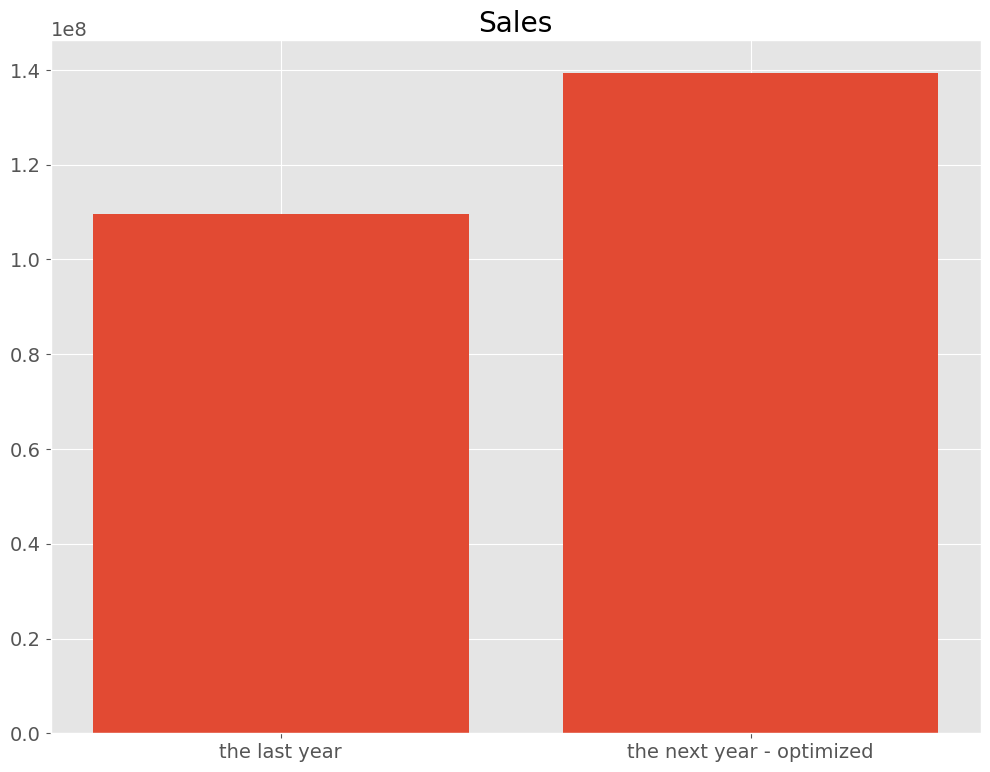

In [44]:
#
# グラフ化：売上
#

labels = ['the last year','the next year - optimized']
values = [Sales_actual,Sales_optimized]

plt.title('Sales')
plt.bar(labels, values)
plt.show()

In [47]:
#
# 最適予算配分（構成比）
#

# 直近1年（実績）の構成比
X_actual_ratio = X[-term:].sum()/X[-term:].sum().sum()

print('直近1年（実績）の構成比:\n'
      + str(X_actual_ratio)
      + '\n')

# 今後1年（最適配分時）の構成比
X_plan_ratio = X_plan.sum()/X_plan.sum().sum()

print('今後1年（最適配分時）の構成比::\n'
      + str(X_plan_ratio)
      + '\n')

直近1年（実績）の構成比:
TVCM         0.397076
Newspaper    0.339156
Web          0.263768
dtype: float64

今後1年（最適配分時）の構成比::
TVCM         0.311447
Newspaper    0.364923
Web          0.323630
dtype: float64



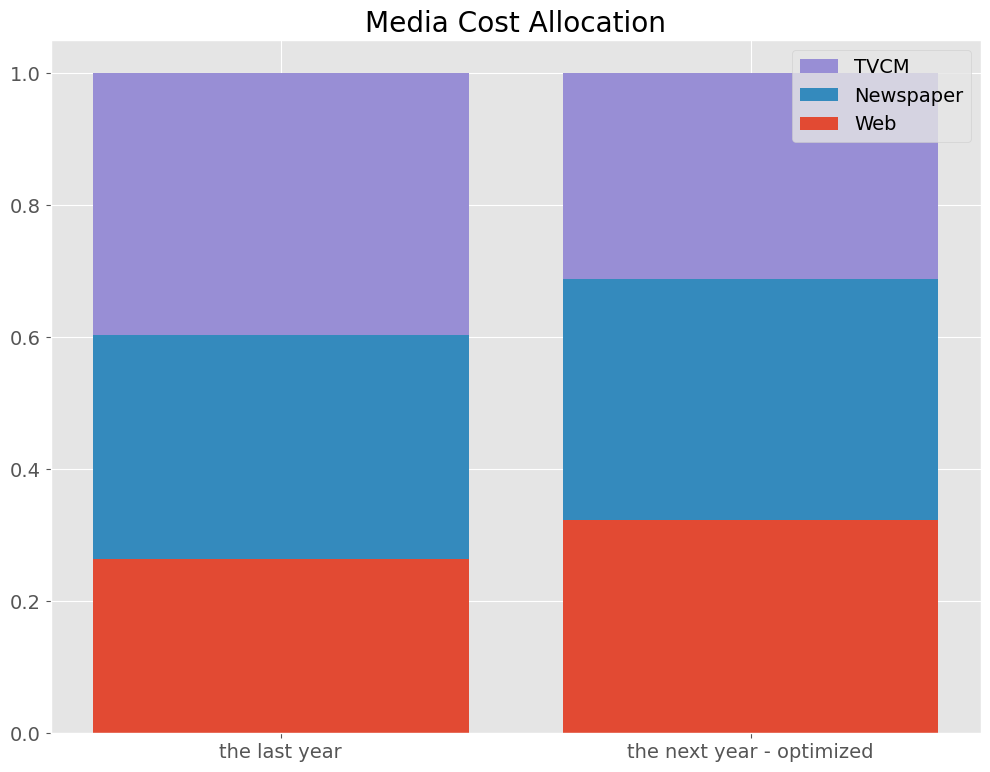

In [48]:
#
# グラフ化：最適予算配分（構成比）
#

labels = ['the last year','the next year - optimized']

TVCM_values = np.array([X_actual_ratio[0],X_plan_ratio[0]])
Newspaper_values = np.array([X_actual_ratio[1],X_plan_ratio[1]])
Web_values = np.array([X_actual_ratio[2],X_plan_ratio[2]])

fig, ax = plt.subplots()

ax.bar(labels, Web_values, label='Web')
ax.bar(labels, Newspaper_values, bottom=Web_values, label='Newspaper')
ax.bar(labels, TVCM_values, bottom=Web_values+Newspaper_values, label='TVCM')

ax.set_title('Media Cost Allocation')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

plt.show()